In [1]:
from sklearn.datasets import fetch_california_housing


import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from typing import Sequence
from typing import Tuple
from typing import Callable
from abc import abstractmethod
import sklearn.metrics as sk_metrics
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import inspect
from typing import Callable, Mapping, Union, List
import random
import scipy
import argparse

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
class Checkpointer:
    """A simple PyTorch model load/save wrapper."""

    def __init__(
        self,
        log_dir: str = 'output',
        device: str = 'cpu',
        random_state: int = None,  # 시드를 추가로 받음
    ) -> None:
        """Constructs a simple load/save checkpointer."""
        if random_state is not None:
            # 랜덤 시드를 디렉토리 이름에 추가
            log_dir = os.path.join(log_dir, f"seed_{random_state}")
        self._ckpt_dir = os.path.join(log_dir, "ckpts")
        self._device = device
        os.makedirs(self._ckpt_dir, exist_ok=True)

    def save(
        self,
        model,
        epoch: int,
    ) -> str:
        """Saves the model to the ckpt_dir/epoch/model.pt file."""
        ckpt_path = os.path.join(self._ckpt_dir, "model-{}.pt".format(epoch))
        torch.save({
            'model_state_dict': model.state_dict(),
            'attributes': vars(model),
            'class': type(model)
            }, 
            ckpt_path
        )
        return ckpt_path

    def load(
        self,
        epoch: int,
    ) -> nn.Module:
        """Loads the model from the ckpt_dir/epoch/model.pt file."""
        ckpt_path = os.path.join(self._ckpt_dir, "model-{}.pt".format(epoch))
        ckpt = torch.load(ckpt_path, map_location=self._device)
        constructor = ckpt['class']
        constructor_args = inspect.getfullargspec(constructor).args
        args = {k: v for k, v in ckpt['attributes'].items() if k in constructor_args}
        model = constructor(**args)
        model.load_state_dict(ckpt['model_state_dict'])
        return model

In [3]:
from torch.utils.data import DataLoader, TensorDataset

In [4]:
    # 컬럼 이름 정의
    column_names = [
    "longitude", "latitude", "housingMedianAge", "totalRooms",
    "totalBedrooms", "population", "households", "medianIncome",
    "medianHouseValue"
    ]
    data = pd.read_csv("cal_housing.data", header=None, names=column_names)
    # 파생 변수 생성
    data["AveRooms"] = data["totalRooms"] / data["households"]  # 1가구당 평균 방 개수
    data["AveBedrms"] = data["totalBedrooms"] / data["households"]  # 1가구당 평균 침실 개수
    data["AveOccup"] = data["population"] / data["households"]  # 1가구당 평균 거주 인원 수
    # 필요 없는 열 제거
    data = data.drop(columns=["totalRooms", "totalBedrooms", "households"])  # 'households' 제거
   
    # 타겟 변수 변환 (단위: 10만 달러)
    data["medianHouseValue"] = data["medianHouseValue"] / 100000
    
    X = data.drop(columns=['medianHouseValue'])  # "Rings"이 종속 변수
    y = data['medianHouseValue']
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_processed = pd.DataFrame(X_scaled, columns=X.columns)
    
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=0)

In [5]:
# 열 이름 정의
feature_names = [
    'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
    'Latitude', 'Longitude'
]

# 데이터 로드
cal_housing = np.loadtxt("cal_housing.data", delimiter=",")

# 열 순서 조정 (논문 코드에서 사용된 columns_index 순서)
columns_index = [8, 7, 2, 3, 4, 5, 6, 1, 0]  # 논문에 나온 대로 재배치
cal_housing = cal_housing[:, columns_index]

# 타겟과 독립 변수 분리
target, data = cal_housing[:, 0], cal_housing[:, 1:]

# 파생 변수 계산
data[:, 2] /= data[:, 5]  # AveRooms = totalRooms / households
data[:, 3] /= data[:, 5]  # AveBedrms = totalBedrooms / households
data[:, 5] = data[:, 4] / data[:, 5]  # AveOccup = population / households

# 타겟 변환 (10만 단위)
target = target / 100000.0

# X, y 생성
X = pd.DataFrame(data, columns=feature_names)
y = target

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_processed = pd.DataFrame(X_scaled, columns=X.columns)
    
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=0)


In [6]:
import matplotlib.pyplot as plt

In [88]:
    # 컬럼 이름 정의
    column_names = [
    "longitude", "latitude", "housingMedianAge", "totalRooms",
    "totalBedrooms", "population", "households", "medianIncome",
    "medianHouseValue"
    ]
    data = pd.read_csv("cal_housing.data", header=None, names=column_names)
    data['medianHouseValue'] = data['medianHouseValue'] / 100000
    X = data.drop(columns=['medianHouseValue'])  # "Rings"이 종속 변수
    y = data['medianHouseValue']
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_processed = pd.DataFrame(X_scaled, columns=X.columns)
    
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=0)

In [98]:
# Initialize Checkpointer
checkpointer = Checkpointer(log_dir='ca_housing/nam2/output/0', device='cpu', random_state=0)

# Load the model
model = checkpointer.load(epoch='best')

In [33]:
# Convert X_test to a tensor if required by the model
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Step 3: Make predictions using the loaded model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions, _ = model(X_test_tensor)  # If the model returns a tuple, extract predictions

# Step 4: Calculate RMSE
rmse = mean_squared_error(y_test, predictions.numpy(), squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.563850185829247


/home/statyoung/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
def plot_feature_outputs_individual(model, X_train, feature_names=None, num_points=100):
    """
    Plots (x_i, f_i(x_i)) for each feature using the trained NAM model.
    
    Args:
        model: Trained NAM model (single learner).
        X_train: Training data used to define feature ranges.
        feature_names: List of feature names for labeling.
        num_points: Number of points for generating feature plots.
    """
    num_features = X_train.shape[1]
    
    # If feature_names is not provided or its length doesn't match num_features
    if feature_names is None or len(feature_names) != num_features:
        feature_names = [f"Feature {i+1}" for i in range(num_features)]
    
    for i in range(num_features):
        # Generate evenly spaced values for feature i
        x_min, x_max = X_train[:, i].min(), X_train[:, i].max()
        x_range = np.linspace(x_min, x_max, num_points).reshape(-1, 1)
        
        # Prepare input tensor with other features set to their mean values
        inputs = torch.tensor(np.zeros((num_points, num_features)), dtype=torch.float32)
        inputs[:, i] = torch.tensor(x_range.squeeze(), dtype=torch.float32)

        # Get the output for the current feature
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            outputs = model.calc_outputs(inputs)  # Use calc_outputs for feature-level outputs
            feature_output = outputs[i].cpu().numpy()

        # Plot (x_i, f_i(x_i)) for the current feature
        plt.figure(figsize=(8, 6))  # Larger size for individual plots
        plt.plot(x_range, feature_output, label=f"f_{i+1}(x_{i+1})", color='skyblue')
        plt.xlabel(feature_names[i])
        plt.ylabel('Contribution to Prediction')
        plt.title(f'Feature: {feature_names[i]} Contribution to Prediction')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

In [11]:
X_train

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome
12069,0.677291,0.137088,0.098039,0.012717,0.011639,0.006306,0.010525,0.257838
15925,0.190239,0.551541,1.000000,0.060507,0.076195,0.041537,0.073343,0.268265
11162,0.632470,0.137088,0.490196,0.043644,0.059590,0.028560,0.060352,0.236783
4904,0.606574,0.156217,0.725490,0.017676,0.032123,0.020909,0.033712,0.066578
4683,0.596614,0.163656,1.000000,0.060303,0.093110,0.031727,0.094557,0.184591
...,...,...,...,...,...,...,...,...
13123,0.307769,0.608927,0.372549,0.033369,0.035382,0.019872,0.035849,0.269831
19648,0.344622,0.524973,0.509804,0.028384,0.030106,0.018050,0.034205,0.166453
9845,0.244024,0.429330,0.588235,0.036345,0.057263,0.019647,0.064463,0.186053
10799,0.639442,0.114772,0.647059,0.053996,0.077126,0.029401,0.076797,0.353899


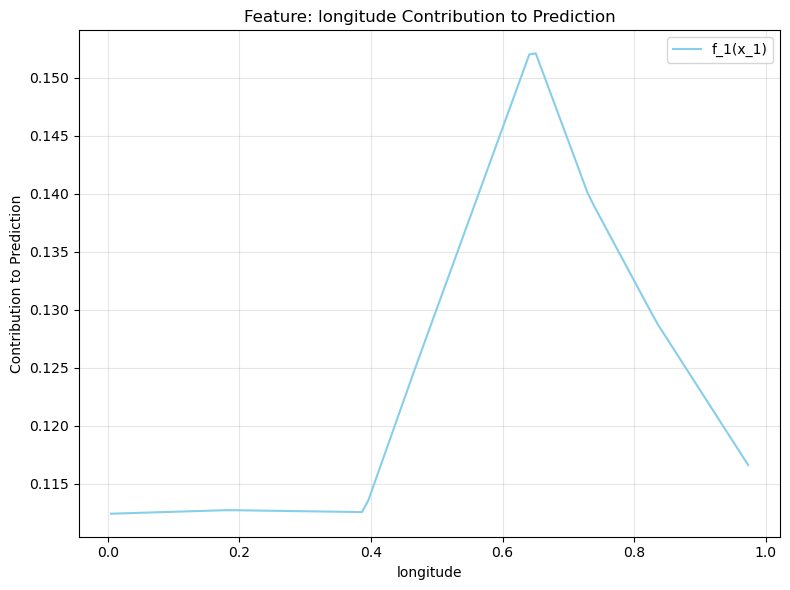

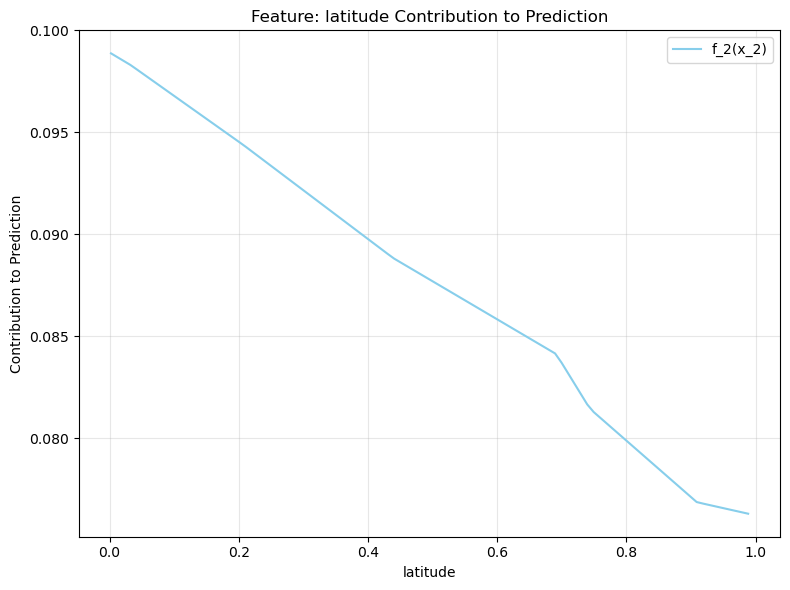

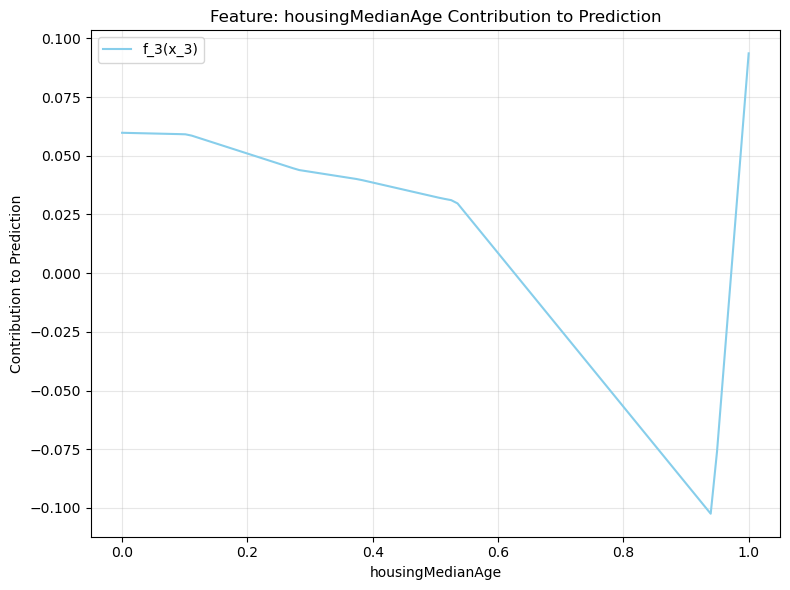

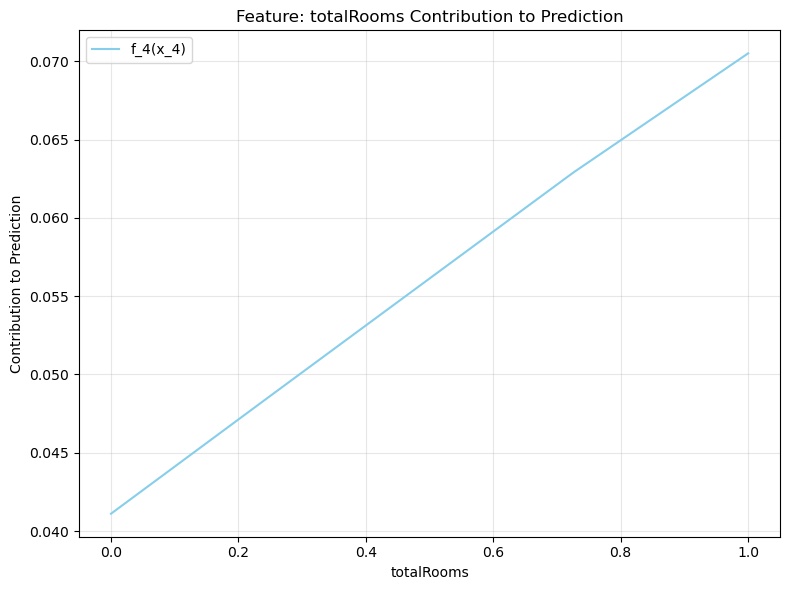

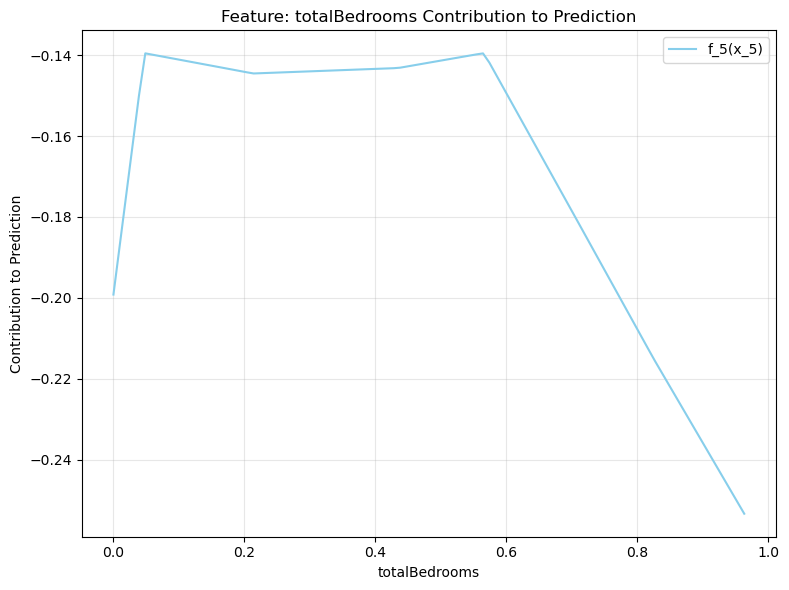

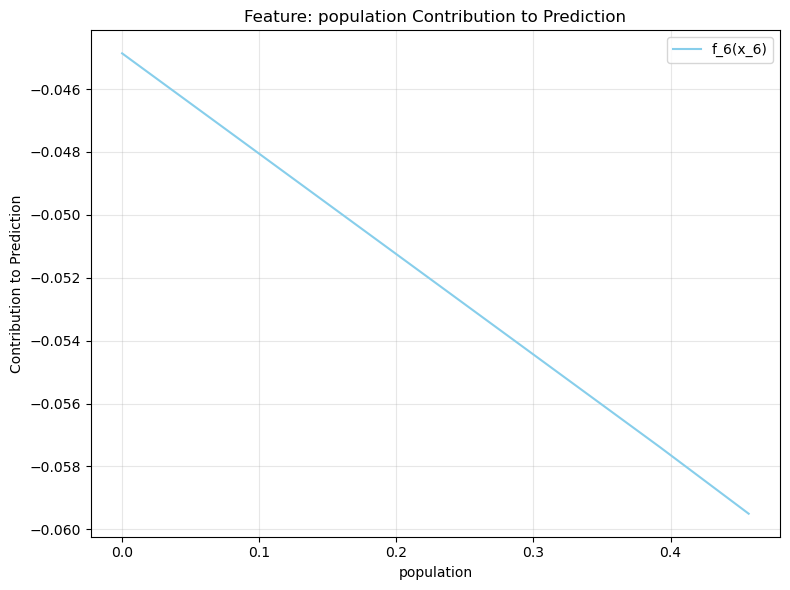

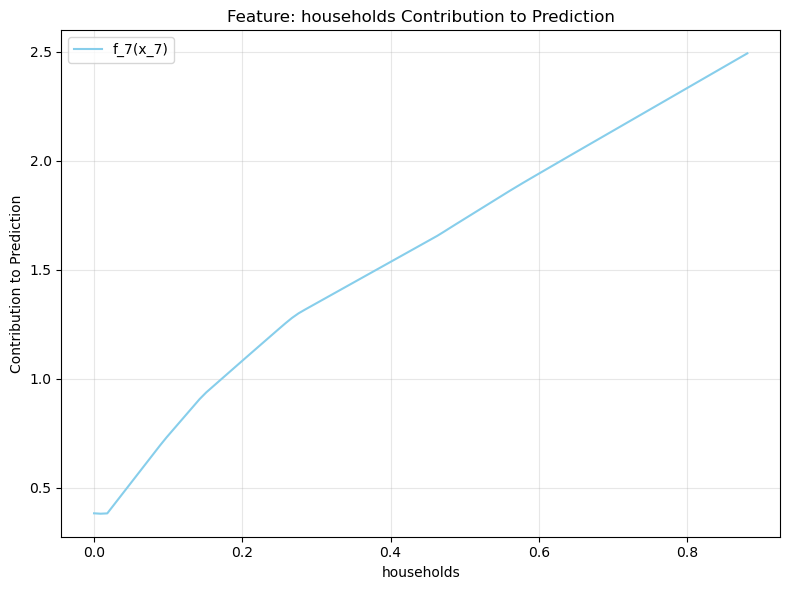

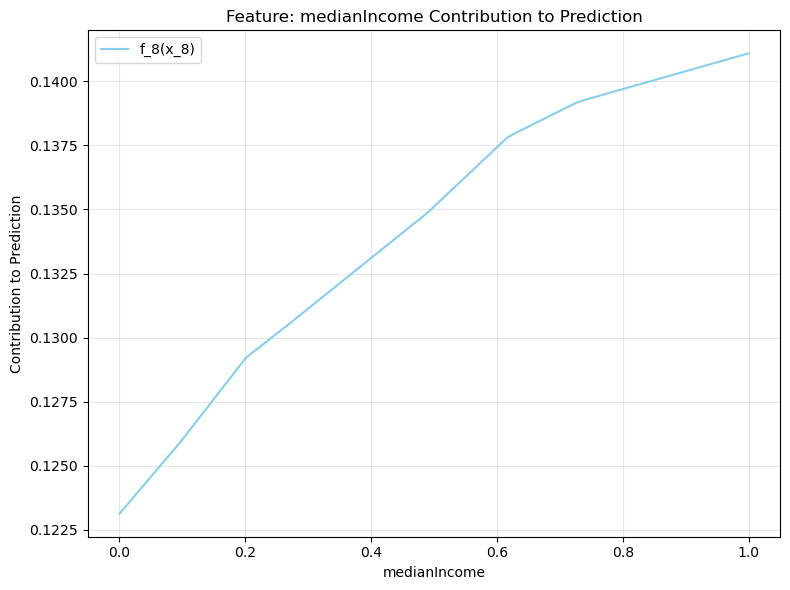

In [35]:
# 피처별 기여도 시각화
plot_feature_outputs_individual(
    model=model,
    X_train=X_test.values,
    feature_names=X_train.columns.tolist(),
    num_points=100
)

In [99]:
def plot_feature_outputs_individual(model, X_train, feature_names=None, num_points=100):
    """
    Plots (x_i, f_i(x_i) - E[f_i(x)]) for each feature using the trained NAM model.
    Forces y-axis scale to [-5, 5].

    Args:
        model: Trained NAM model (single learner).
        X_train: Training data used to define feature ranges.
        feature_names: List of feature names for labeling.
        num_points: Number of points for generating feature plots.
    """
    num_features = X_train.shape[1]

    # If feature_names is not provided or its length doesn't match num_features
    if feature_names is None or len(feature_names) != num_features:
        feature_names = [f"Feature {i+1}" for i in range(num_features)]

    for i in range(num_features):
        # Generate evenly spaced values for feature i
        x_min, x_max = X_train[:, i].min(), X_train[:, i].max()
        x_range = np.linspace(x_min, x_max, num_points).reshape(-1, 1)

        # Prepare input tensor with other features set to their mean values
        inputs = torch.tensor(np.zeros((num_points, num_features)), dtype=torch.float32)
        inputs[:, i] = torch.tensor(x_range.squeeze(), dtype=torch.float32)

        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            # Calculate feature-level outputs
            outputs = model.calc_outputs(inputs)
            feature_output = outputs[i].cpu().numpy()

        # Compute the mean value E[f_j(x)] over the training data for feature j
        feature_mean_input = torch.tensor(X_train, dtype=torch.float32)
        with torch.no_grad():
            feature_mean_output = model.calc_outputs(feature_mean_input)
            mean_correction = feature_mean_output[i].mean().cpu().numpy()

        # Adjust feature outputs by subtracting E[f_j(x)]
        adjusted_output = feature_output - mean_correction

        # Plot adjusted (x_i, f_i(x_i) - E[f_i(x)])
        plt.figure(figsize=(10, 8))  # Increase figure size
        plt.plot(x_range, adjusted_output, color='blue', linewidth=2.5)  # Change to a darker blue and thicker line
        plt.xlabel(feature_names[i], fontsize=50, fontweight='bold')  # Increase font size and make bold
        plt.ylabel(f'$f_{i+1}(x_{i+1})$', fontsize=60, fontweight='bold')  # Larger and bold Y-axis label
        plt.title(f'{feature_names[i]} effect on Prediction', fontsize=20, fontweight='bold')  # Increase title size and bold
        plt.ylim(-5, 5)  # Force y-axis to [-5, 5]
        plt.grid(alpha=0.5)  # Make the grid more visible
        plt.xticks(fontsize=14)  # Increase X-axis tick font size
        plt.yticks(fontsize=14)  # Increase Y-axis tick font size
        plt.tight_layout()
        plt.show()


In [101]:
# Initialize Checkpointer
checkpointer = Checkpointer(log_dir='ca_housing/nam2/output/0', device='cpu', random_state=0)

# Load the model
model = checkpointer.load(epoch='best')

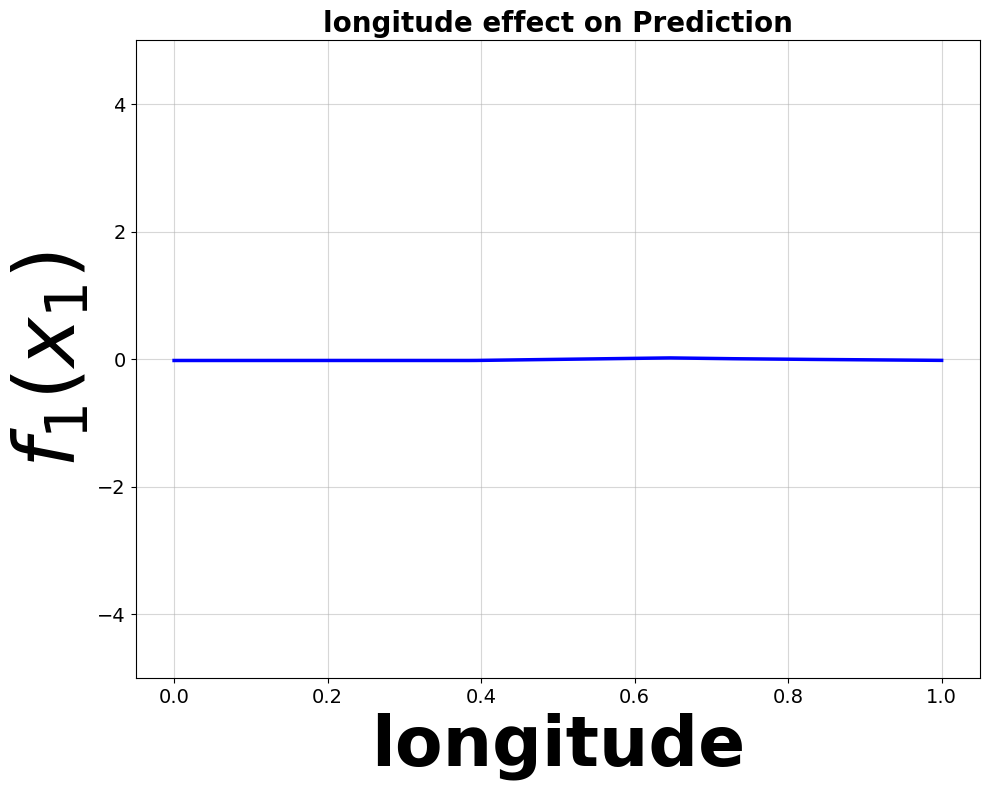

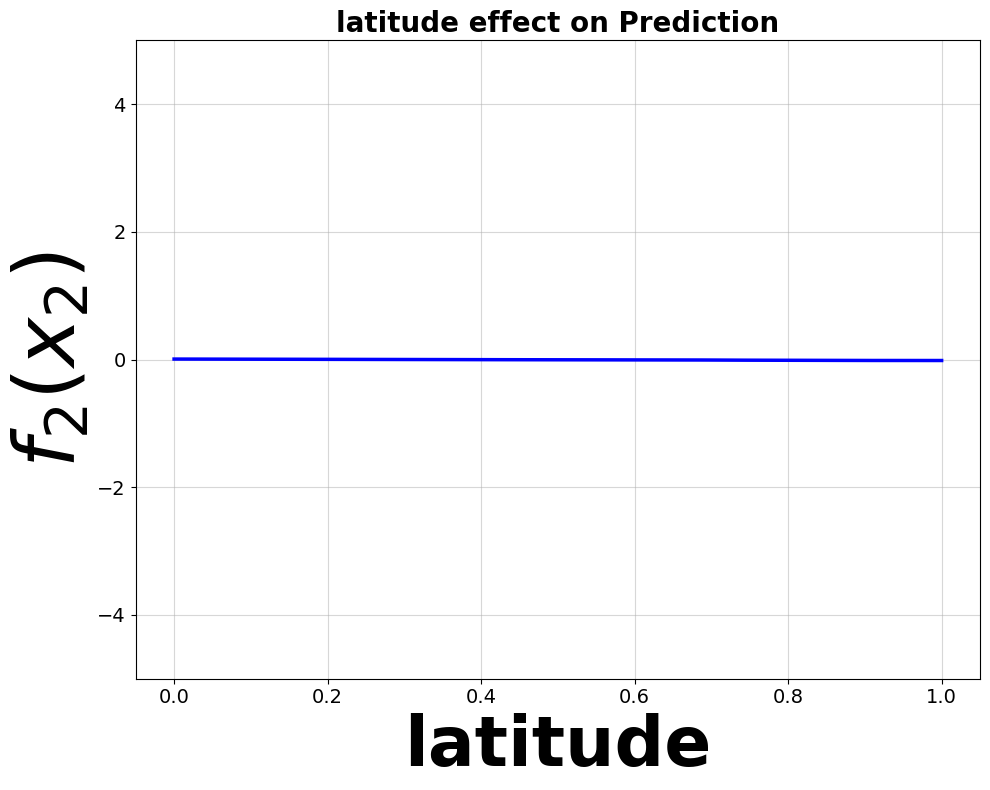

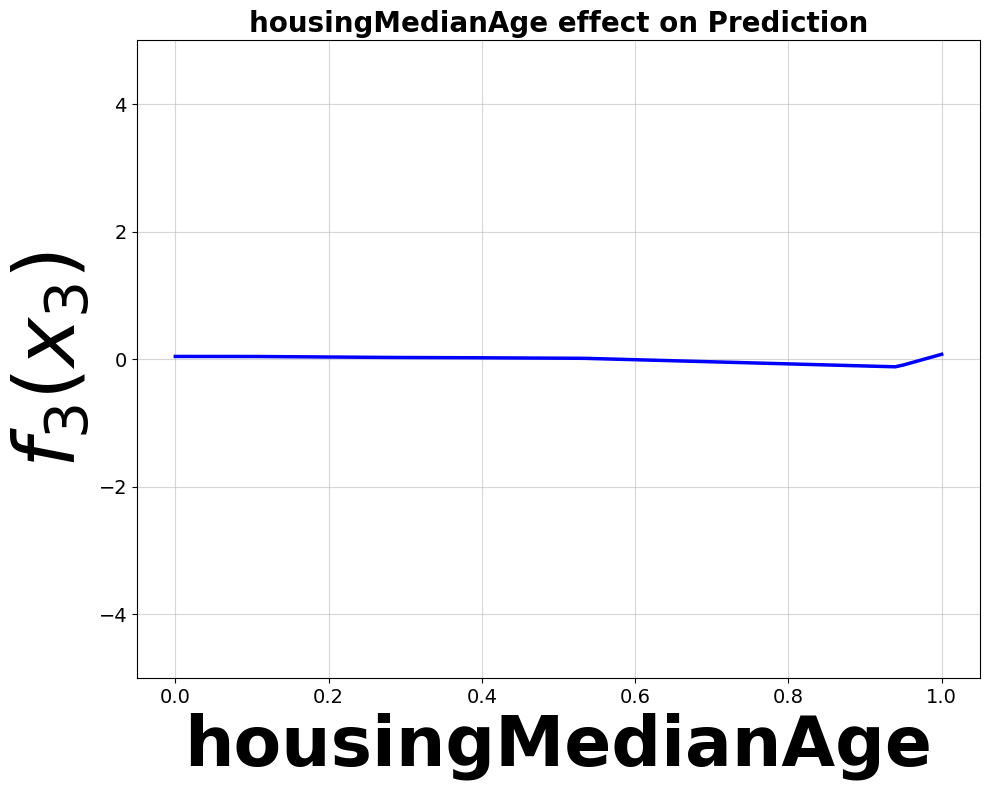

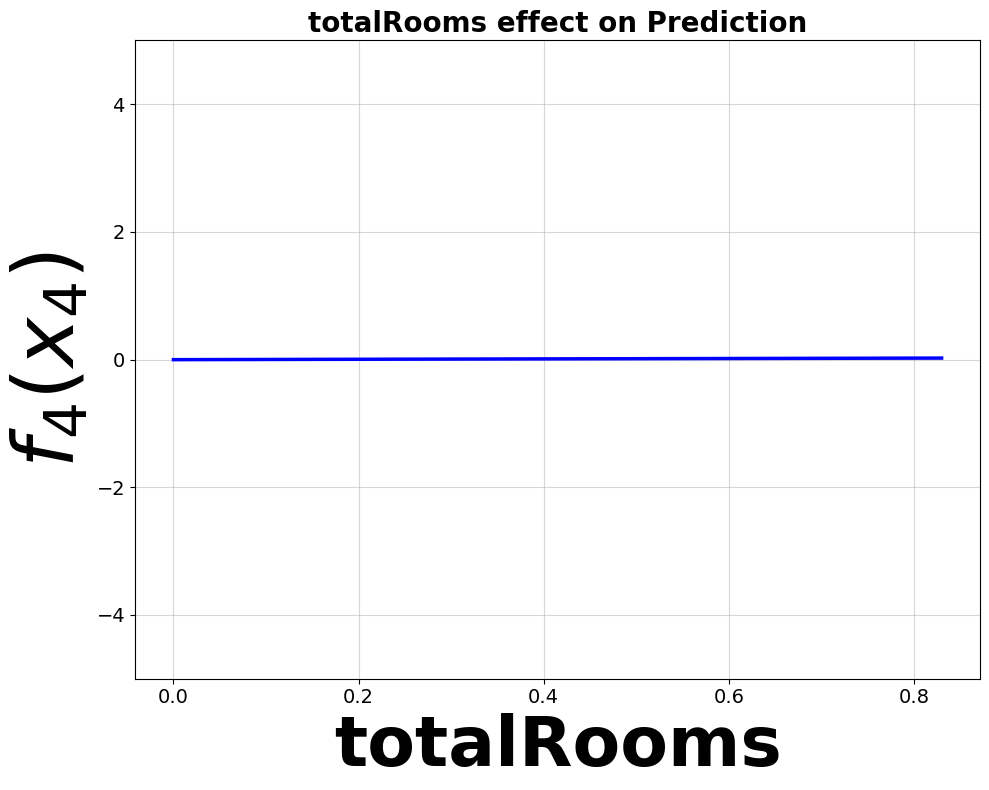

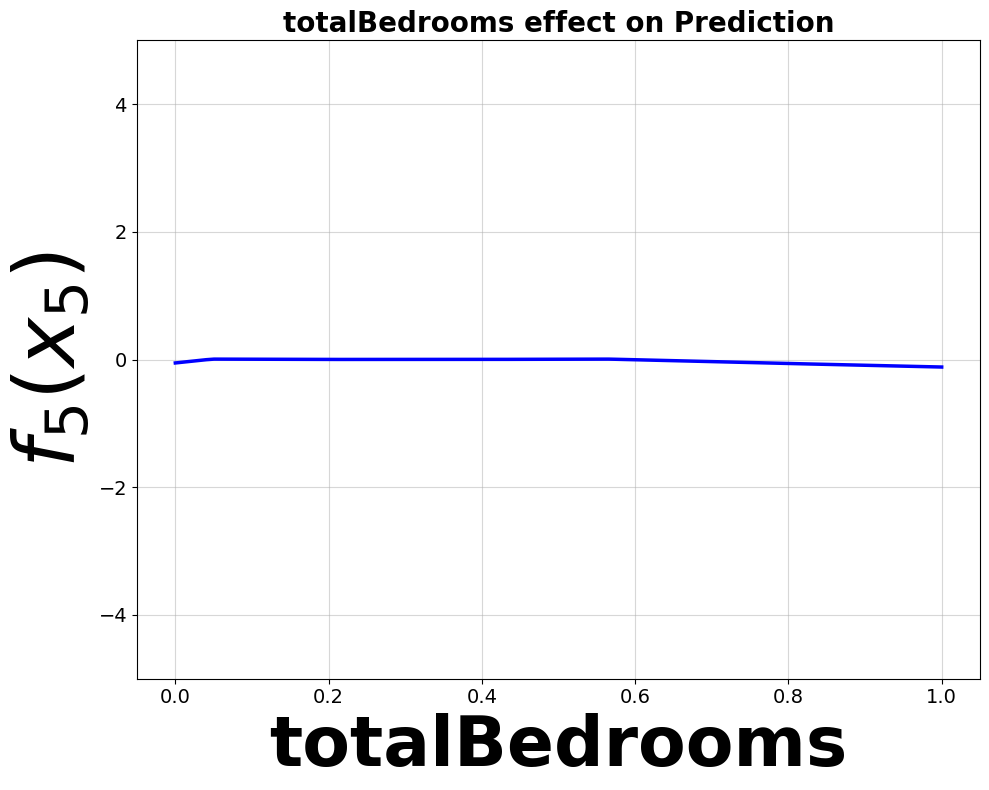

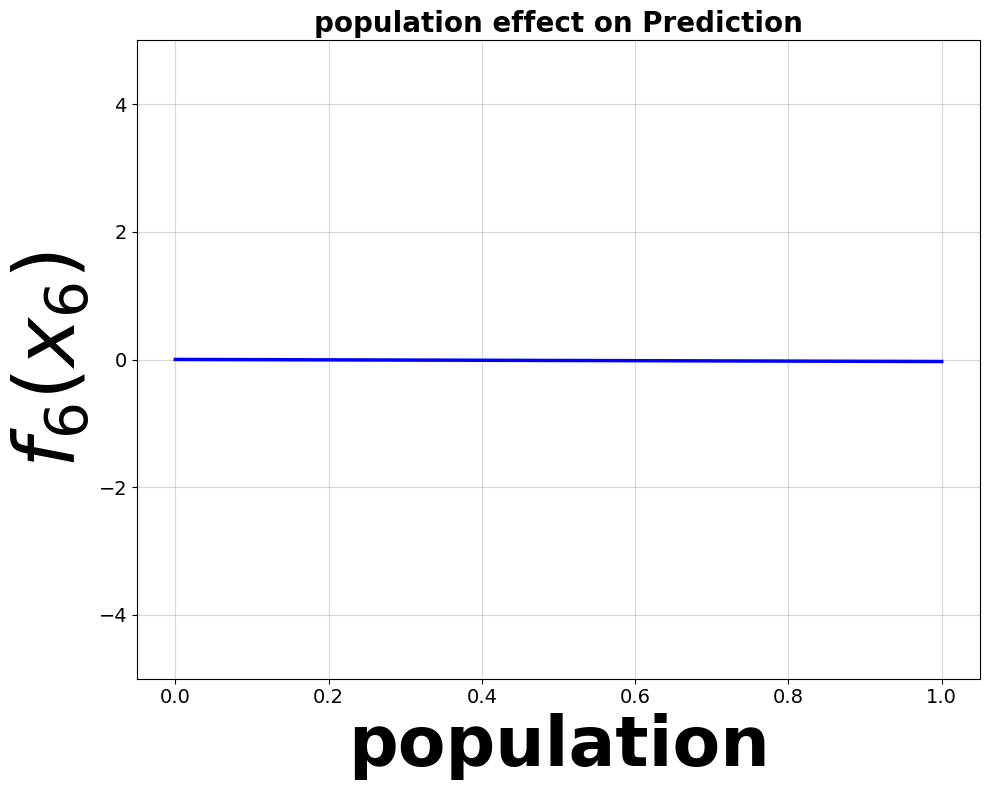

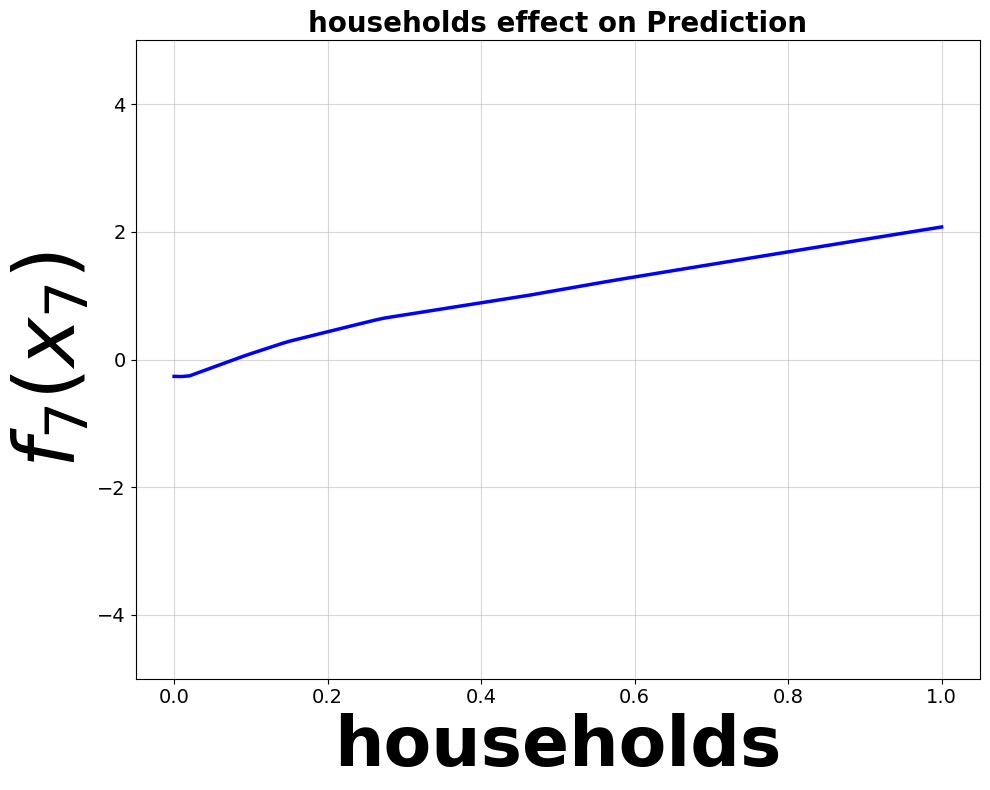

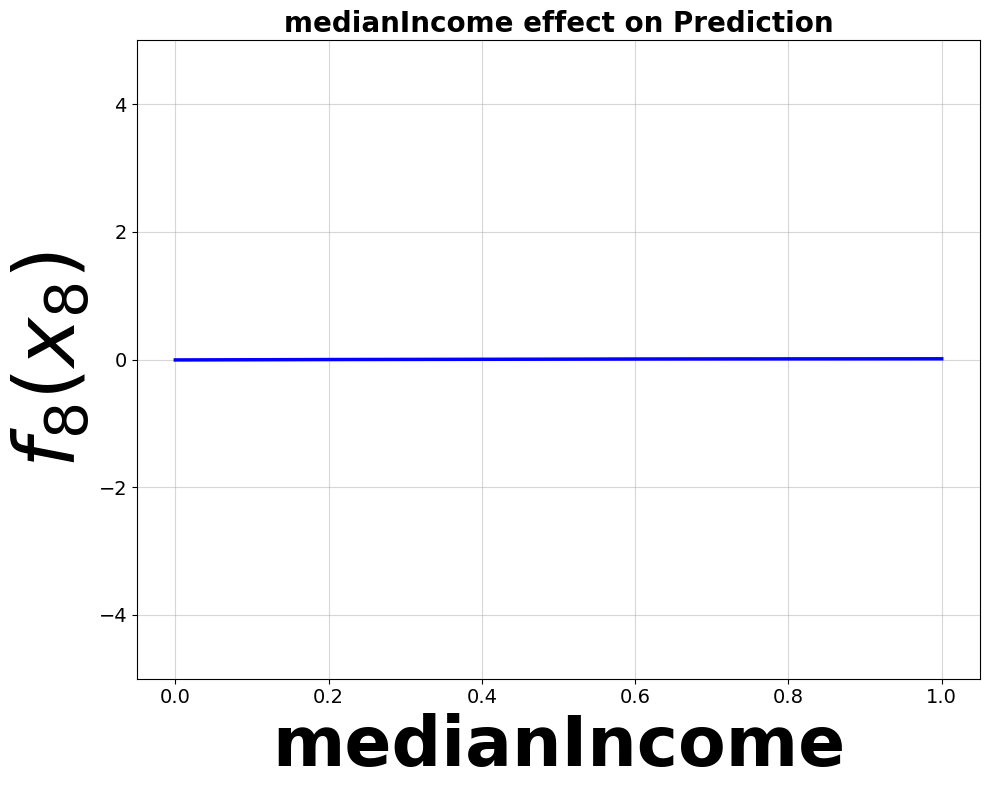

In [102]:
# 피처별 기여도 시각화
plot_feature_outputs_individual(
    model=model,
    X_train=X_train.values,
    feature_names=X_train.columns.tolist(),
    num_points=100
)

In [13]:
from ucimlrepo import fetch_ucirepo 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [59]:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.datasets import load_breast_cancer

    # 컬럼 이름 정의
    column_names = [
    "longitude", "latitude", "housingMedianAge", "totalRooms",
    "totalBedrooms", "population", "households", "medianIncome",
    "medianHouseValue"
    ]
    data = pd.read_csv("cal_housing.data", header=None, names=column_names)
    data['medianHouseValue'] = data['medianHouseValue'] / 100000
    X = data.drop(columns=['medianHouseValue'])  # "Rings"이 종속 변수
    y = data['medianHouseValue']
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    model = RandomForestRegressor()
    model.fit(X_train,y_train)

RandomForestRegressor()

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Apply LIME for a specific instance
explainer = LimeTabularExplainer(
    X_train.values,               # Training data
    feature_names=X_train.columns.tolist(),  # Feature names
    class_names=['HouseValue'],   # Target name
    discretize_continuous=False   # Keep continuous features as-is
)

# Choose an instance to explain (e.g., the first test instance)
instance_to_explain = X_test.iloc[0].values
explanation = explainer.explain_instance(
    instance_to_explain,          # Instance to explain
    model.predict,                # Model's prediction function
    num_samples=1000              # Number of perturbation samples
)

# Visualize the explanation
explanation.show_in_notebook()
explanation.as_pyplot_figure()
plt.show()

IndentationError: unexpected indent (2792169444.py, line 11)

In [ ]:
len(

20640

/home/statyoung/.local/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


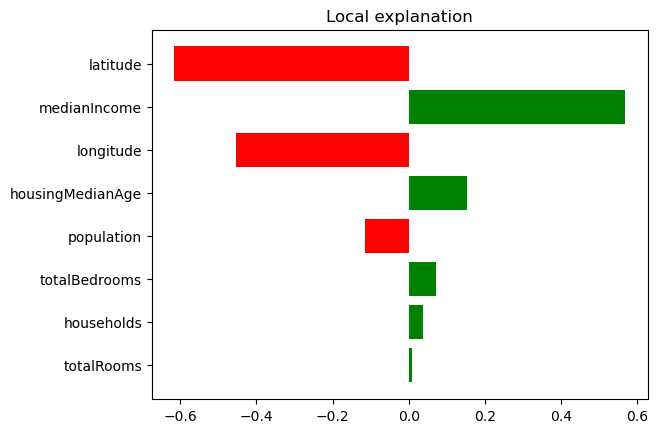

In [67]:
explainer = LimeTabularExplainer(
    X_train.values,               # Training data
    feature_names=X_train.columns.tolist(),  # Feature names
    class_names=['HouseValue'],   # Target name (optional in regression)
    discretize_continuous=False,  # Keep continuous features as-is
    mode="regression"             # Set mode to regression
)

# Choose an instance to explain (e.g., the first test instance)
instance_to_explain = X_test.iloc[0].values
explanation = explainer.explain_instance(
    instance_to_explain,          # Instance to explain
    model.predict,                # Model's prediction function
    num_samples=1000              # Number of perturbation samples
)

# Visualize the explanation
explanation.show_in_notebook()
explanation.as_pyplot_figure()
plt.show()

In [70]:
random_state = 42

/home/statyoung/.local/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


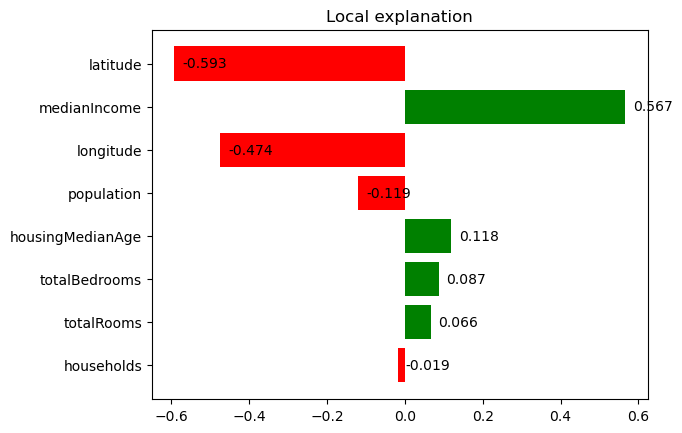

In [75]:
# Set random seed for reproducibility
np.random.seed(42)

# Create the explainer
explainer = LimeTabularExplainer(
    X_train.values,               # Training data
    feature_names=X_train.columns.tolist(),  # Feature names
    class_names=['HouseValue'],   # Target name (optional in regression)
    discretize_continuous=False,  # Keep continuous features as-is
    mode="regression"             # Set mode to regression
)

# Choose an instance to explain (e.g., the first test instance)
instance_to_explain = X_test.iloc[0].values

# Explain the same instance with the model
explanation = explainer.explain_instance(
    instance_to_explain,          # Instance to explain
    model.predict,                # Model's prediction function
    num_samples=1000              # Number of perturbation samples
)

# Visualize the explanation and add feature values to the plot
fig = explanation.as_pyplot_figure()
ax = fig.gca()  # Get the current axes

# Get feature contributions and sort them to match plot order
feature_contributions = dict(explanation.as_list())  # Convert to dictionary for easy access

# Sort features by their order in the plot
sorted_features = [text.get_text() for text in ax.get_yticklabels()]  # Extract feature names from plot
sorted_contributions = [feature_contributions[feature] for feature in sorted_features]  # Match contributions

# Add text annotations for each bar
for bar, value in zip(ax.patches, sorted_contributions):
    ax.text(
        bar.get_width() + 0.02,  # Position text slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Center text vertically
        f"{value:.3f}",  # Format the contribution value
        va='center'
    )

plt.show()
